# **L1 regularization for feature selection**

Purpose: study the influence different predictors on the heavy motion model for ships.

Reference: https://github.com/aalvarell/ship-movement-dataset

Include dependencies:

In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

First, import training and test datasets and normalized the predictors:

In [35]:
# Load the datasets from the 'Dataset' folder
train_file_path = 'Dataset/heave_train.csv'
test_file_path = 'Dataset/heave_test.csv'

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Select meteorological and ship characteristics as input features
input_features = ['h_s', 't_p', 'dir', 'wind_speed', 'wind_dir', 'h_0', 'h_sm', 'length', 'breath', 'dwt', 'zone']

# The output variable (target) for this example will be 'heave' (represented by 'mov_avg')
X_train = train_df[input_features]
y_train = train_df['mov_avg']  # Assuming 'mov_avg' represents the heave motion

X_test = test_df[input_features]
y_test = test_df['mov_avg']  # Using the same target variable in the test dataset

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Apply linear regression to see possible overfitting n the model:

In [38]:
# Apply Linear Regression (L1 Regularization)
linearReg = LinearRegression().fit(X_train_scaled, y_train)

# Predict on training and test sets
y_train_pred = linearReg.predict(X_train_scaled)
y_test_pred = linearReg.predict(X_test_scaled)

# Calculate R^2 and RMSE for training set
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Calculate R^2 and RMSE for test set
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Print the training and test set scores
print(f"Linear Regression - Training set R²: {r2_train:.2f}")
print(f"Linear Regression - Training set RMSE: {rmse_train:.2f}")
print(f"Linear Regression - Test set R²: {r2_test:.2f}")
print(f"Linear Regression - Test set RMSE: {rmse_test:.2f}")

Linear Regression - Training set R²: 0.79
Linear Regression - Training set RMSE: 0.05
Linear Regression - Test set R²: -2.55
Linear Regression - Test set RMSE: 0.10


Now, let's apply L1 (or Lasso) procedure:

Best alpha: 0.005428675439323859
Best R^2 score on test data: -2.0107028415899224


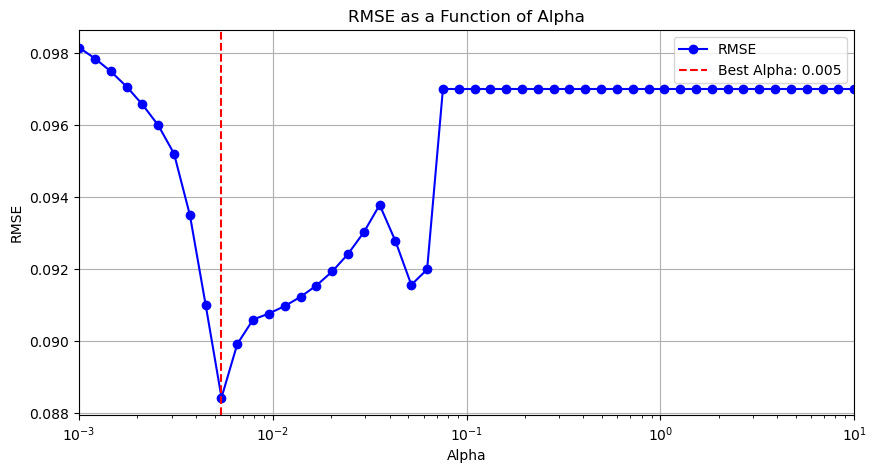

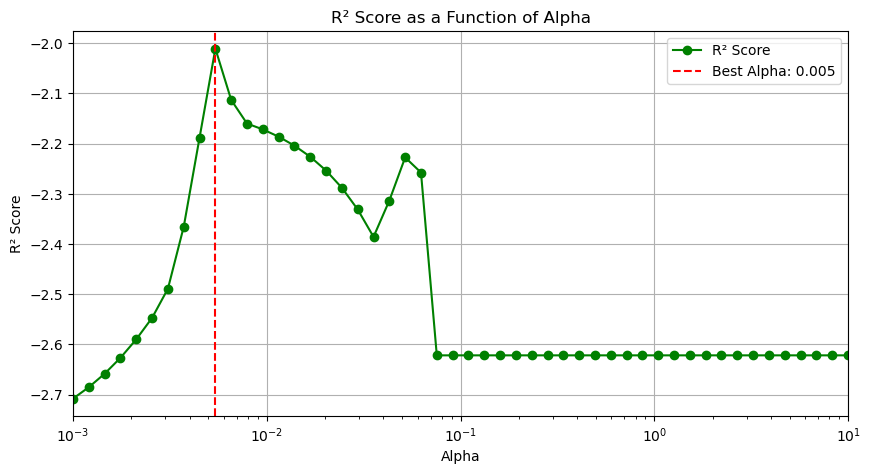

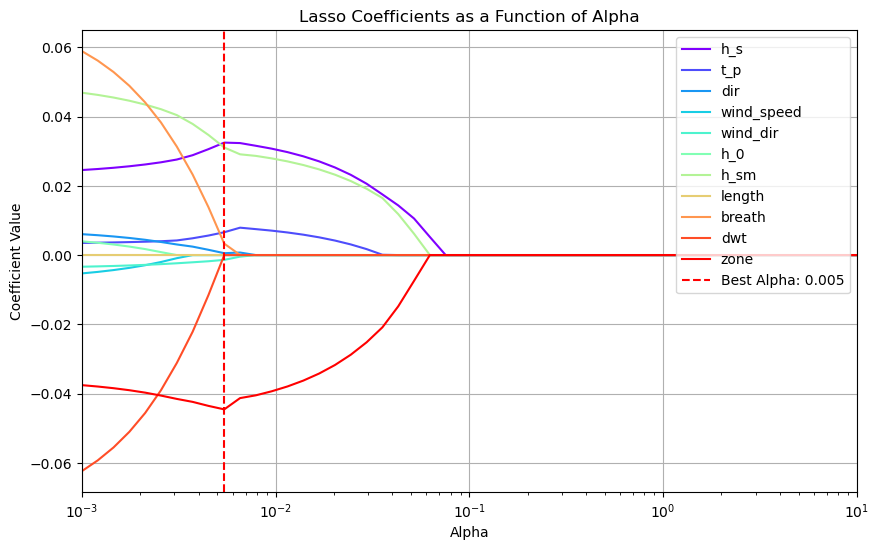

In [34]:
# Create a range of alpha values
alphas = np.logspace(-3, 1, 50)

# Store coefficients for each alpha value
coefficients = []

# Track the best Lasso model based on the test set performance
best_alpha = None
best_r2 = -np.inf
best_lasso = None

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train)
    coefficients.append(lasso.coef_)
    
    # Evaluate the model on the test set
    y_pred = lasso.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)  # R^2 score for test set
    
    if r2 > best_r2:
        best_r2 = r2
        best_alpha = alpha
        best_lasso = lasso

coefficients = np.array(coefficients)

# Print the best alpha and R^2 score on the test set
print(f"Best alpha: {best_alpha}")
print(f"Best R^2 score on test data: {best_r2}")

# Plotting the coefficients as a function of alpha
colors = cm.rainbow(np.linspace(0, 1, len(input_features)))

# Plotting the RMSE as a function of alpha
plt.figure(figsize=(10, 5))
plt.plot(alphas, rmse_values, marker='o', label='RMSE', color='blue')
plt.axvline(x=best_alpha, color='red', linestyle='--', label=f'Best Alpha: {best_alpha:.3f}')  # Best alpha line
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE as a Function of Alpha')
plt.grid(True)
plt.legend()
plt.xlim([alphas[0], alphas[-1]]) 
plt.show()

# Plotting the R² score as a function of alpha
plt.figure(figsize=(10, 5))
plt.plot(alphas, r2_values, marker='o', label='R² Score', color='green')
plt.axvline(x=best_alpha, color='red', linestyle='--', label=f'Best Alpha: {best_alpha:.3f}')  # Best alpha line
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('R² Score as a Function of Alpha')
plt.grid(True)
plt.legend()
plt.xlim([alphas[0], alphas[-1]]) 
plt.show()

# Optionally, display the coefficients as a function of alpha
colors = cm.rainbow(np.linspace(0, 1, len(input_features)))
plt.figure(figsize=(10, 6))
for i, (col, color) in enumerate(zip(input_features, colors)):
    plt.plot(alphas, coefficients[:, i], label=col, color=color)

plt.axvline(x=best_alpha, color='red', linestyle='--', label=f'Best Alpha: {best_alpha:.3f}')  # Best alpha line
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients as a Function of Alpha')
plt.legend(loc='upper right')
plt.xlim([alphas[0], alphas[-1]]) 
plt.grid(True)
plt.show()

**Comments:** the plots show the dependency of the coefficient alpha in the prediction process. In both RMSE and R^2 the best alpha value corresponds to the peaks. Moreover, from the coefficient value plot, it is possible to conclude that the variable h_s (i.e. the significant wave height, i.e., the mean of the highest third of the waves in a time series of waves representing a certain sea state measured by a buoy) has the highest correlation with y (heave movement). This is an expected result, indeed the higher the waves, the higher is the motion of the ship in the z-axis direction.

Now, let's evaluate R^2 and RMSE for the best value of alpha:

In [40]:
# Optionally, display the test set performance of the best model
y_test_pred = best_lasso.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Lasso - Test set RMSE: {mse_test}")
print(f"Lasso - Test set R²: {r2_test}")

Lasso - Test set RMSE: 0.00782132278322913
Lasso - Test set R²: -2.0107028415899224


**Comments:** the R^2 score shows a better model prediction, since it is closer to 0.

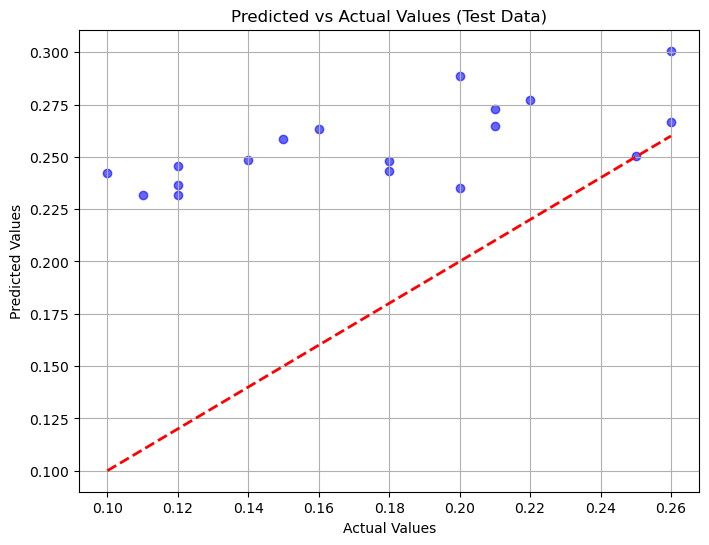

In [10]:
y_test_pred = best_lasso.predict(X_test_scaled)

# Plot the predicted values against the actual values in the test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)  # Diagonal reference line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Test Data)')
plt.grid(True)
plt.show()

**Comments:** the plot shows that the predicted and actual values don't match a lot, but this is the maximum we can do with the provided datasets.